In [1]:
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import torchviz
from matplotlib import cm

from bubble_control.bubble_learning.datasets.bubble_drawing_dataset import BubbleDrawingDataset
from bubble_control.bubble_learning.aux.load_model import load_model_version
from bubble_control.bubble_learning.aux.img_trs.block_upsampling_tr import BlockUpSamplingTr
# models
from bubble_control.bubble_learning.models.bubble_dynamics_model import BubbleDynamicsModel
from bubble_control.bubble_model_control.aux.bubble_dynamics_fixed_model import BubbleDynamicsFixedModel
from bubble_control.bubble_learning.models.bubble_linear_dynamics_model import BubbleLinearDynamicsModel
from bubble_control.bubble_learning.models.object_pose_dynamics_model import ObjectPoseDynamicsModel

from bubble_utils.bubble_datasets.dataset_transformed import transform_dataset
from bubble_control.bubble_learning.aux.remove_nontensor_elements_tr import RemoveNonTensorElementsTr

from bubble_utils.bubble_tools.bubble_img_tools import process_bubble_img, unprocess_bubble_img

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Bubble Data Examples

In [2]:
dataset_path = '/home/mmint/bubble_datasets/drawing_data_one_direction'
save_path = '/home/mmint/Desktop/architecture_details_test'

In [3]:
dataset = BubbleDrawingDataset(dataset_path)
# filter out non tensor elements to be able to batch it with dataloader
remove_nontensor_elements_tr = RemoveNonTensorElementsTr()
trs = (remove_nontensor_elements_tr,)
filtered_dataset = transform_dataset(dataset, transforms=trs)

In [4]:
cmap = cm.get_cmap('jet')

In [ ]:
def custom_imshow(*args, )

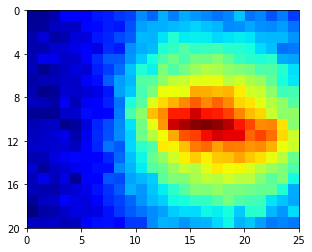

In [33]:
def visualize_image(img, **kwargs):
    fig, ax = plt.subplots(1,1)
    
    # plt.imshow(img, cmap='jet')
    ax.imshow(img, **kwargs, extent=[0,img.shape[1],img.shape[0],0])


    num_x_labels = 6
    num_y_labels = 6
    x_label_list = np.arange(num_x_labels)*img.shape[1]/(num_x_labels-1)
    y_label_list = np.arange(num_y_labels)*img.shape[0]/(num_y_labels-1)
    x_label_list = x_label_list.astype(np.int32)
    y_label_list = y_label_list.astype(np.int32)
    ax.set_xticks(x_label_list)
    ax.set_yticks(y_label_list)
    return ax

img = dataset[0]['init_imprint'][0]
visualize_image(img, cmap='jet')



In [26]:
def view_bubble(def_img, ref_img, cmap='jet'):
    cmap = cm.get_cmap(cmap)
    
        
    depth_values = ref_img - def_img 
#     depth_values = def_img - ref_img 
    print(np.max(depth_values),np.min(depth_values))
    max_depth = 0.011
    min_depth = 0.002

   
    def color_tr(depth_values):
        maped_depth = ((depth_values-min_depth)/(max_depth-min_depth))# between (0,1)
        colors = cmap(maped_depth)[...,:3]
        return colors
        
    colors = color_tr(depth_values)
        
    return colors, color_tr

0.011234567 -0.005914144


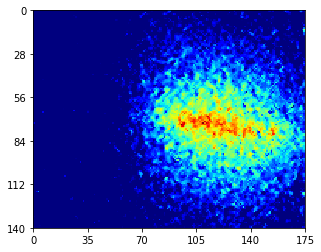

In [34]:
fc = 0
dl_line = dataset.dl.iloc[fc]
scene_name = dl_line['Scene']
undef_fc = int(dl_line['UndeformedFC'])
init_fc = int(dl_line['InitialStateFC'])
final_fc = int(dl_line['FinalStateFC'])
depth_img_r = dataset._load_depth_img(init_fc, scene_name, camera_name='right')#[...,0]
depth_img_r_ref = dataset._load_depth_img(undef_fc, scene_name, camera_name='right')#[...,0]
depth_img_r_porcessed = process_bubble_img(depth_img_r)[...,0]
depth_img_r_ref_porcessed = process_bubble_img(depth_img_r_ref)[...,0]

colored_depth_img_r, color_tr = view_bubble(depth_img_r_porcessed, depth_img_r_ref_porcessed)
# plt.imshow(colored_depth_img_r)

visualize_image(colored_depth_img_r, cmap='jet')
# plt.imshow(depth_img_r)
# plt.imshow(depth_img_r_ref)

0.011234567 -0.005914144


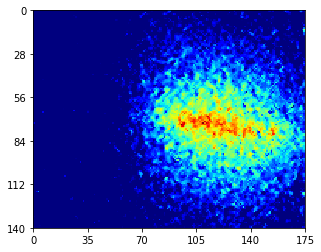

In [34]:
fc = 0
dl_line = dataset.dl.iloc[fc]
scene_name = dl_line['Scene']
undef_fc = int(dl_line['UndeformedFC'])
init_fc = int(dl_line['InitialStateFC'])
final_fc = int(dl_line['FinalStateFC'])
depth_img_r = dataset._load_depth_img(init_fc, scene_name, camera_name='right')#[...,0]
depth_img_r_ref = dataset._load_depth_img(undef_fc, scene_name, camera_name='right')#[...,0]
depth_img_r_porcessed = process_bubble_img(depth_img_r)[...,0]
depth_img_r_ref_porcessed = process_bubble_img(depth_img_r_ref)[...,0]

colored_depth_img_r, color_tr = view_bubble(depth_img_r_porcessed, depth_img_r_ref_porcessed)
# plt.imshow(colored_depth_img_r)

visualize_image(colored_depth_img_r, cmap='jet')
# plt.imshow(depth_img_r)
# plt.imshow(depth_img_r_ref)

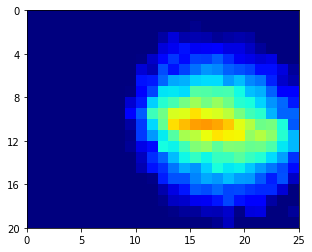

In [35]:
factor_x = 7
factor_y = 7
dataset.block_mean_downsampling_tr.factor_x = factor_x
dataset.block_mean_downsampling_tr.factor_y = factor_y
imprint_downsampled = dataset.block_mean_downsampling_tr._tr(depth_img_r_ref_porcessed - depth_img_r_porcessed)
# plt.imshow(color_tr(imprint_downsampled))
visualize_image(color_tr(imprint_downsampled), cmap='jet')

In [169]:
dataset.block_mean_downsampling_tr.factor_x

7

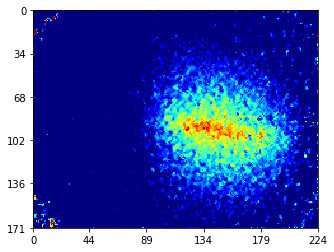

In [36]:
# plt.imshow(color_tr((depth_img_r_ref-depth_img_r)[...,0]))
visualize_image(color_tr((depth_img_r_ref-depth_img_r)[...,0]), cmap='jet')

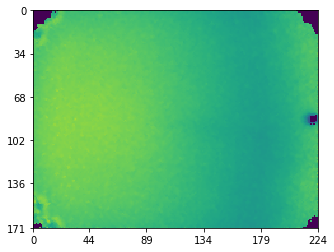

In [37]:
# plt.imshow((depth_img_r)[...,0])
visualize_image((depth_img_r)[...,0])

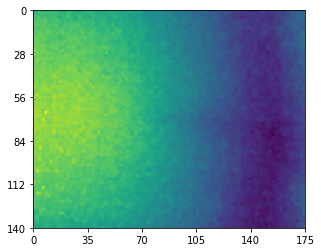

In [39]:
# plt.imshow(depth_img_r_porcessed)
visualize_image(depth_img_r_porcessed)

----

In [41]:
def sample_to_batch(sample):
#     sample_tr = 
    batched_sample = {}
    for key, value in sample.items():
        batched_sample[key] = value.unsqueeze(0)
    return batched_sample

In [42]:
batch_0 = sample_to_batch(filtered_dataset[0])

# Visualize model

In [43]:
model_path = '/home/mmint/Desktop/drawing_models'

In [44]:
bubble_dynamics_model = load_model_version(BubbleDynamicsModel, model_path, 0)
bubble_dynamics_model.eval()

BubbleDynamicsModel(
  (object_embedding_module): PointNetObjectEmbedding(
    (pointnet_classifier): PointNetClassifier(
      (base): PointNetBase(
        (input_transformer): Transformer(
          (block1): Sequential(
            (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
          (block2): Sequential(
            (0): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
            (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
          (block3): Sequential(
            (0): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
            (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
          (mlp): Sequential(
            (0): Linear(in_features=1024, out_features=512, bias=True)
            (1): B

In [45]:

model_input = bubble_dynamics_model.get_model_input(batch_0) + (batch_0['action'],)

out = bubble_dynamics_model(*model_input)

dot = torchviz.make_dot(out, params=dict(bubble_dynamics_model.named_parameters()), show_attrs=True, show_saved=True)
dot.render('/home/mmint/Desktop/trochviz_test')


'/home/mmint/Desktop/trochviz_test.pdf'

In [46]:
for input_i in model_input:
    print(input_i.shape)

torch.Size([1, 2, 20, 25])
torch.Size([1, 6])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 144, 3])
torch.Size([1, 3])


In [47]:
imprint_pred = out[0][0]

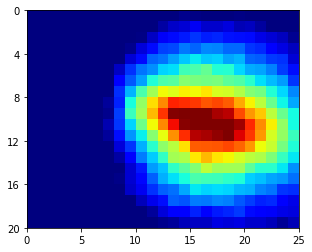

In [55]:
img = color_tr(imprint_pred[0].cpu().detach().numpy())

visualize_image(img)

In [49]:
imprint_pred.shape

torch.Size([2, 20, 25])

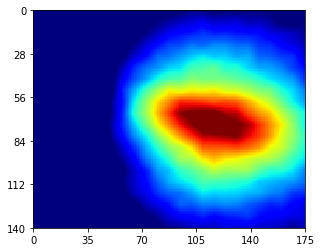

In [54]:
upsampling_tr = BlockUpSamplingTr(factor_x=factor_x, factor_y=factor_y, method='bilinear')

imprint_pred_upsampled = upsampling_tr._tr(imprint_pred)


img = color_tr(imprint_pred_upsampled[0].cpu().detach().numpy())

visualize_image(img)